[*********************100%%**********************]  1 of 1 completed

2024-08-17 03:21:38.511397
2004-08-17 03:21:38.511397



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


0.04409098905752986
0.09999705186806988
0.021787944043499853
0.05470458696236748
0.04691037456785035
0.10526080579230493
0.07172984309302194
0.12171406462016167
0.06394591563721144


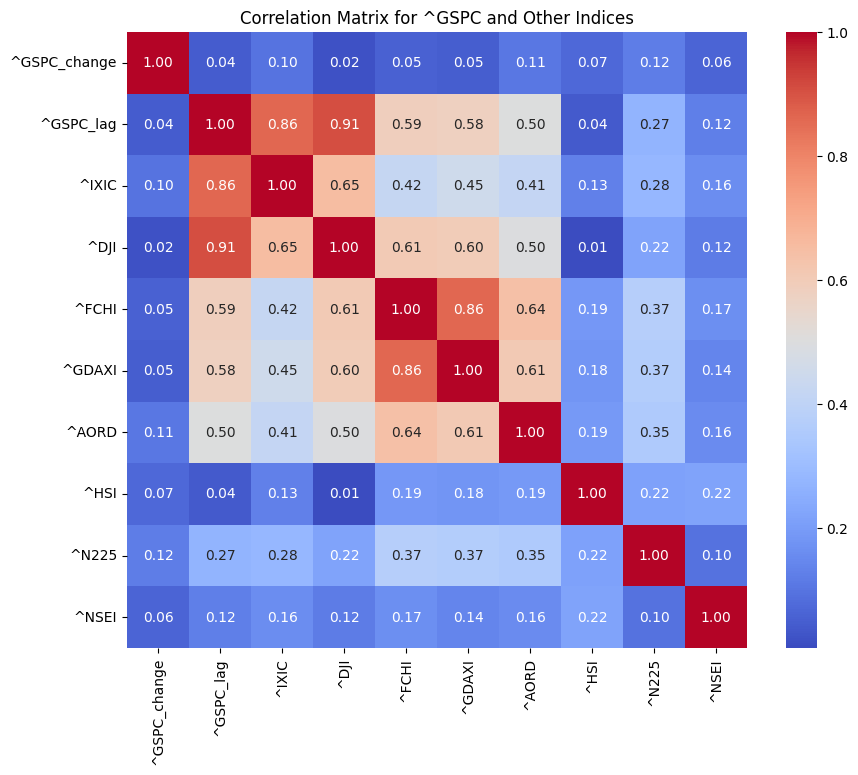

(51.42052124911951, 48.5325193707443)
(54.848555999060814, 45.10448462080301)
(50.55177271660014, 49.40126790326368)
(51.42052124911951, 48.5559990608124)
(51.678797839868515, 48.274242779995305)
(52.876262033341156, 46.959380136182205)
(53.46325428504344, 46.46630664475229)
(54.23808405729045, 45.71495656257337)
(53.5571730453158, 46.395867574548014)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


(3407, 6)
      ^GSPC_lag       ^IXIC       ^AORD        ^HSI       ^N225       ^NSEI
3467   7.700195   93.889648  -13.000000   17.000000   63.410156   53.150391
3468  17.479980   43.540039   39.500000  285.550781  -71.121094   21.000000
3469  10.449707   17.000000   -6.100098  -98.189453  -64.640625 -100.649414
3470   8.310059   91.380859   -7.799805 -297.791016 -114.830078  -59.049805
3471  -2.560059    0.659180   19.500000 -279.951172 -104.781250  -55.400391
...         ...         ...         ...         ...         ...         ...
4254  37.219727  157.121094   37.799805    8.669922 -247.339844   26.949219
4255  25.100098  151.099609   13.700195   13.849609  741.933594 -203.349609
4256  65.379883  282.900391   28.000000 -120.320312  -93.171875  -40.650391
4257  58.770020  166.898438   13.599609  100.929688  345.242188  -40.650391
4258  29.370117 -166.939453  106.100098  144.121094  757.742188  206.300781

[792 rows x 6 columns]
(3407, 1)
(792, 1)
torch.Size([3397, 10, 6])
torch.Siz

In [12]:
%run Predictions.ipynb

### Final Model Predictions on entire Dataset

In [13]:
predictions_tensors = torch.cat(predictions, dim=0)
predictions_list = predictions_tensors.flatten().tolist()

In [19]:
calc_profit_df = final_df[['Date', f'{target_stock}_change', 'Price', 'Close']].iloc[test_index:]

calc_profit_df_top10 = calc_profit_df.iloc[:10]
calc_profit_df_top10 = calc_profit_df_top10.copy()
calc_profit_df_bot10 = calc_profit_df.iloc[10:].reset_index(drop=True)

calc_profit_df_top10['Predicted_Gain'] = np.nan
calc_profit_df_bot10['Predicted_Gain'] = pd.DataFrame(predictions_list, columns=['Predicted_Gain'])
calc_profit_df = pd.concat([calc_profit_df_top10, calc_profit_df_bot10])
# print(calc_profit_df)

           Date  ^GSPC_change        Price        Close  Predicted_Gain
3476 2021-07-08      8.310059  4321.069824  4320.819824             NaN
0    2021-07-09     43.030273  4329.379883  4369.549805       -0.244713
1    2021-07-12      8.659668  4372.410156  4384.629883        8.213682
2    2021-07-13     -0.959961  4381.069824  4369.209961       -2.698539
3    2021-07-14    -11.089844  4380.109863  4374.299805       -0.825176
...         ...           ...          ...          ...             ...
777  2024-08-12     25.100098  5351.879883  5344.390137       14.481790
778  2024-08-13     65.379883  5376.979980  5434.430176       -1.127102
779  2024-08-14     58.770020  5442.359863  5455.209961       10.843482
780  2024-08-15     29.370117  5501.129883  5543.220215        3.660569
781  2024-08-16     29.370117  5530.500000  5553.470215       21.287655

[783 rows x 5 columns]


In [20]:
# Utilise Bollinger Bands to gauge trend and decide on whether to long or short
def calc_profit(data):
    # Applying Bollinger Bands with Exponential Moving Average
    window = 20  
    data['EMA'] = data['Price'].ewm(span=window, adjust=True).mean()
    data['STD'] = data['Price'].rolling(window=window).std()
    data['Upper_Band'] = data['EMA'] + (2 * data['STD'])
    data['Lower_Band'] = data['EMA'] - (2 * data['STD'])
    data.dropna(inplace=True, ignore_index=True)
    
    # Decide on whether to short or long the stock
    orders = []
    for _, row in data.iterrows():
        if row['Price'] > row['Upper_Band']:
            orders.append(-1)
        elif row['Price'] < row['Lower_Band']:
            orders.append(1)
        elif row['Predicted_Gain'] > 0:
            orders.append(1)
        elif row['Predicted_Gain'] < 0:
            orders.append(-1) 
    
    data['Order'] = pd.DataFrame(orders, columns=['Order'])
     
    data['Profit Per Trade'] = data[f'{target_stock}_change'] * data['Order']
    data['Cumulative Profit'] = data['Profit Per Trade'].cumsum()
    data['Hold'] = data[f'{target_stock}_change'].cumsum()
    return data

In [21]:
final_df = calc_profit(calc_profit_df)

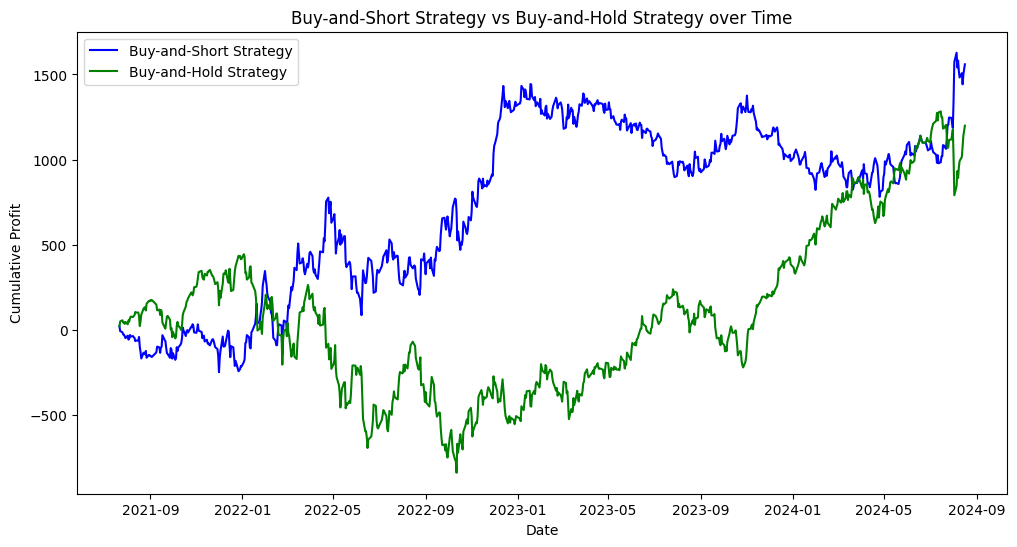

In [26]:
plt.figure(figsize=(12, 6))

plt.plot(final_df['Date'], final_df['Cumulative Profit'], label='Buy-and-Short Strategy', color='blue')
plt.plot(final_df['Date'], final_df['Hold'], label='Buy-and-Hold Strategy', color='green')
# Plotting Price, Upper_Band and Lower_Band
# plt.plot(final_df['Date'], final_df['Upper_Band'], label='Upper_Band', color='red')
# plt.plot(final_df['Date'], final_df['Lower_Band'], label='Lower_Band', color='red')
# plt.plot(final_df['Date'], final_df['Price'], label='Price', color='black')

plt.title('Buy-and-Short Strategy vs Buy-and-Hold Strategy over Time')
plt.xlabel('Date')
plt.ylabel('Cumulative Profit')
plt.legend()
plt.show()

### BackTest Strategy

In [ ]:
def calc_sharpe_ratio(data):
    data['Wealth'] = data['Cumulative Profit'] + data.loc[data.index[0], 'Price']
    data['Return'] =  np.log(data['Wealth']) - np.log(data['Wealth'].shift(1))
    daily_return = data['Return'].dropna()
    daily_sharpe = daily_return.mean() / daily_return.std(ddof=1)
    yearly_sharpe = (252**0.5)*daily_return.mean() / daily_return.std(ddof=1)
    return daily_sharpe, yearly_sharpe

def calc_max_drawdown(data):
    data['Wealth'] = data['Cumulative Profit'] + data.loc[data.index[0], 'Price']
    data['Peak'] = data['Wealth'].cummax()
    data['Drawdown'] = (data['Peak'] - data['Wealth']) / data['Peak']
    max_drawdown = data['Drawdown'].max()
    return max_drawdown